In [1]:
# Imports
import os
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Subset
import copy
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Dataset paths
base_dir = 'chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Transformations
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
      # Normalization for pre-trained models
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
# ])

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

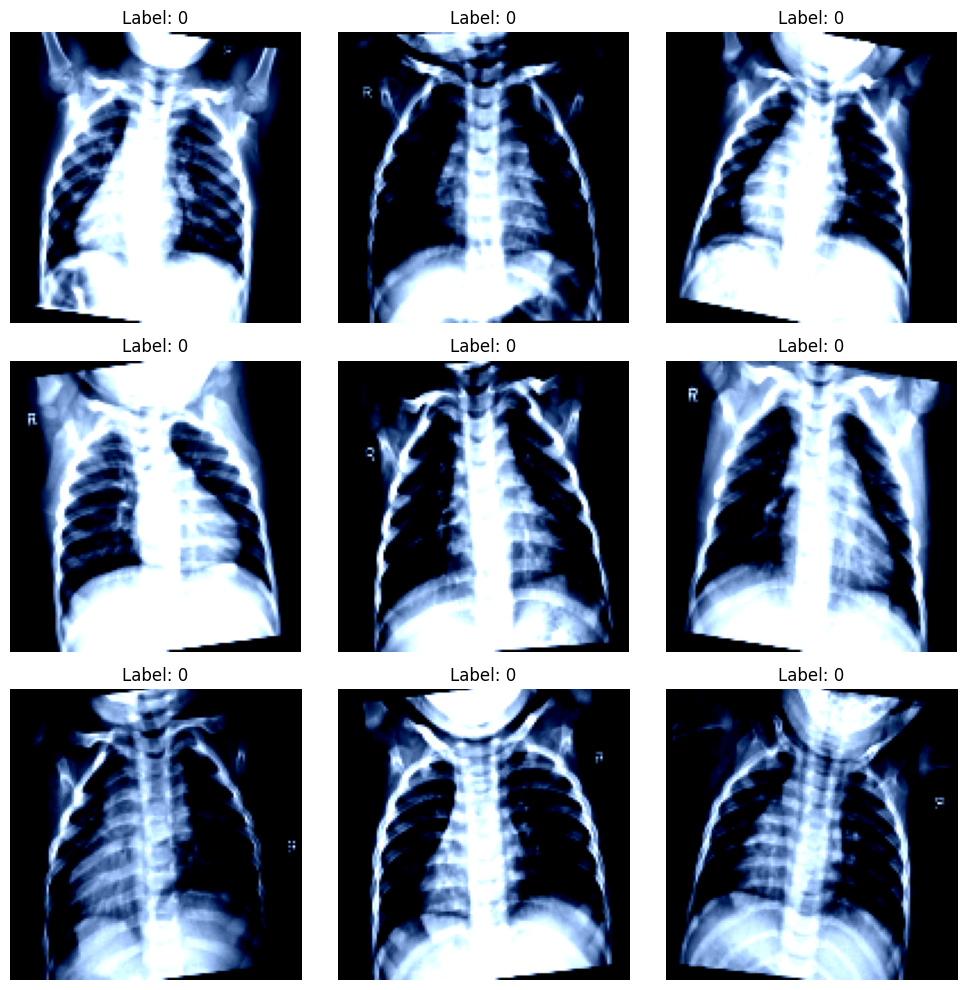

In [3]:
# Display a few sample images from the dataset
def visualize_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        image, label = dataset[i]
        plt.imshow(image.permute(1, 2, 0))  # Convert from CHW to HWC format
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Call the function with the training dataset
visualize_images(train_dataset)

In [4]:
# Define model
def create_model():
    model = models.mobilenet_v2(pretrained=True)
    model.features[18] = nn.Sequential(
        nn.Dropout(p=0.5),  # Dropout layer
        nn.Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False),
        nn.BatchNorm2d(1280)
    )
    model.classifier[1] = nn.Linear(model.last_channel, 1)
    return model
model = create_model()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 140MB/s]


In [5]:
# Federated averaging function
def federated_averaging(models):
    global_model = copy.deepcopy(models[0])
    with torch.no_grad():
        for key in global_model.state_dict().keys():
            # Convert all tensors to float32 for averaging
            tensors = [model.state_dict()[key].data.float() for model in models]
            global_model.state_dict()[key].data.copy_(
                torch.mean(torch.stack(tensors), dim=0)
            )
    return global_model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Number of Clients
num_clients = 5

# Define number of rounds
num_rounds = 10
client_models = [create_model().to(device) for _ in range(num_clients)]

# Split dataset into disjoint subsets
def split_dataset(dataset, num_clients):
    indices = np.arange(len(dataset))
    np.random.shuffle(indices)
    split_indices = np.array_split(indices, num_clients)
    client_datasets = [Subset(dataset, indices) for indices in split_indices]
    return client_datasets

client_datasets = split_dataset(train_dataset, num_clients)
client_dataloaders = [
    DataLoader(client_dataset, batch_size=batch_size, shuffle=True) for client_dataset in client_datasets
]


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#8cf5a2;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;color:black;text-align:center;">MODEL(S) TRAINING</p></div>

In [7]:
# Train function
def train_model(model, dataloader, criterion, optimizer, epochs=1):
    model.train()
    for epoch in range(epochs):
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            # Reshape for BCEWithLogitsLoss
            labels = labels.float().unsqueeze(1)  
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model

In [8]:
# Training setup
global_model = create_model().to(device)
criterion = nn.BCEWithLogitsLoss()

# Initialize client models
client_models = [copy.deepcopy(global_model) for _ in range(num_clients)]

# Federated training loop
num_rounds = 10
for round_num in range(num_rounds):
    print(f"Round {round_num + 1}/{num_rounds}")
    
    # Train each client model
    for i, (client_model, client_dataloader) in enumerate(zip(client_models, client_dataloaders)):
        optimizer = optim.Adam(client_model.parameters(), lr=0.001)
        train_model(client_model, client_dataloader, criterion, optimizer)
    
    # Perform federated averaging
    global_model = federated_averaging(client_models)

    # Distribute updated global model to clients
    for client_model in client_models:
        client_model.load_state_dict(global_model.state_dict())


Round 1/10
Round 2/10
Round 3/10
Round 4/10
Round 5/10
Round 6/10
Round 7/10
Round 8/10
Round 9/10
Round 10/10


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#8cf5a2;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;color:black;text-align:center;">MODEL(S) EVALUATION</p></div>

In [9]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            # Sigmoid for binary classification
            outputs = torch.sigmoid(model(images))
            # Convert logits to binary predictions
            predicted = (outputs > 0.5).float()  
            # Match dimensions for comparison
            correct += (predicted == labels.unsqueeze(1)).sum().item()  
            # Total number of samples
            total += labels.size(0)  
    # Return accuracy as a fraction
    return correct / total  

In [10]:
accuracy = evaluate_model(global_model, val_loader)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 56.25%
